In [ ]:
!pip install numpy pandas matplotlib scipy PyAbel

  Using cached numpy-2.3.4-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pandas-2.3.3-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached matplotlib-3.10.7-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.16.3-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Installing build dependencies ... 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import CubicSpline

ModuleNotFoundError: No module named 'numpy'

In [11]:
#leer el archivo Surface_Br.dat

data = pd.read_csv('Surface_Br.dat', delim_whitespace=True, header=None, names=['Radius[arcsec]', 'Brightness[mag/arcsec^2]'])
data.head()

/tmp/ipykernel_4986/351600219.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('Surface_Br.dat', delim_whitespace=True, header=None, names=['Radius[arcsec]', 'Brightness[mag/arcsec^2]'])


,Radius[arcsec],Brightness[mag/arcsec^2]
0,0.00,15.52
1,0.00,15.60
2,0.00,15.60
3,0.02,15.59
4,0.03,15.66


In [19]:
def abel_inversion(R, I):
    # Aseguramos que los datos estén ordenados
    sort_idx = np.argsort(R)
    R = R[sort_idx]
    I = I[sort_idx]

    # Creamos una función de interpolación para I(R) usando splines cúbicos
    # que son más estables para las derivadas
    I_interp = CubicSpline(R, I)

    # Definimos la función para calcular dI/dR analíticamente usando el spline
    def dIdR(R_val):
        return I_interp.derivative()(R_val)

    # Definimos el integrando de la inversión de Abel
    def integrand(R_prime, r):
        try:
            if np.abs(R_prime - r) < r * 1e-10:  # Manejo especial cerca de la singularidad
                return 0.0
            return -1/np.pi * dIdR(R_prime) / np.sqrt(R_prime**2 - r**2)
        except:
            return 0.0

    j = np.zeros_like(R)
    for i, r in enumerate(R):
        try:
            # Dividimos la integral en regiones para mejor manejo de la singularidad
            r_eps = r * (1 + 1e-10)  # Pequeño offset para evitar la singularidad
            
            # Integramos usando una tolerancia más estricta
            result, error = quad(integrand, r_eps, R[-1], 
                            args=(r,),
                            limit=200,
                            epsabs=1e-8,
                            epsrel=1e-8)
            
            # Verificamos que el error de integración sea razonable
            if error > abs(result) * 0.1:  # Error mayor al 10%
                print(f"Advertencia: Error grande en r = {r:.3f}")
            
            j[i] = result
        except Exception as e:
            print(f"Error en r = {r:.3f}: {str(e)}")
            j[i] = np.nan

    # Devolvemos los resultados en el orden original
    inverse_sort = np.argsort(sort_idx)
    return j[inverse_sort]


In [ ]:
#aplico a los datos disponibles

R = data['Radius[arcsec]'].values
I_mag = data['Brightness[mag/arcsec^2]'].values
I = 10**(-0.4 * I_mag)  # Convertir de mag/arcsec^2 a unidades lineales 

####ACA ME SALIO UN ERROR QUE ANTES NO ESTABA->DEL ORDEN DE LOS rS
j = abel_inversion(R, I) 
j_nl = abel_inversion(R,I_mag)

ValueError: `x` must be strictly increasing sequence.

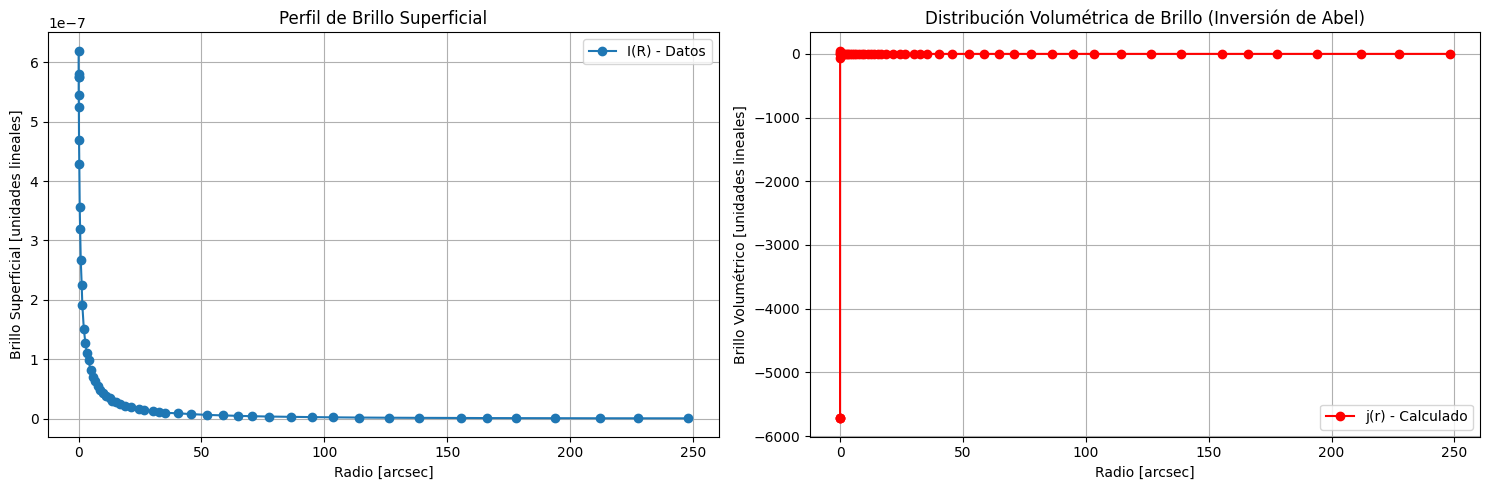

In [ ]:
#ahora, grafico los resultados
plt.figure(figsize=(15, 5))

# Grafico 1: Perfil de Brillo Superficial (lineal)
plt.subplot(1, 2, 1)
plt.plot(R, I, 'o-', label='I(R) - Datos')
plt.xlabel('Radio [arcsec]')
plt.ylabel('Brillo Superficial [unidades lineales]')
plt.title('Perfil de Brillo Superficial')
plt.legend()
plt.grid(True)

# Grafico 2: Distribución Volumétrica de Brillo
plt.subplot(1, 2, 2)
plt.plot(R, j, 'o-', color='r', label='j(r) - Calculado')
plt.xlabel('Radio [arcsec]')
plt.ylabel('Brillo Volumétrico [unidades lineales]')
plt.title('Distribución Volumétrica de Brillo (Inversión de Abel)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Pruebas con funciones conocidas

Ley de potencias (la que hicimos en el parcial)

/tmp/ipykernel_4986/992863956.py:53: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, error = quad(integrand, r_eps, R_sorted[-1], args=(r,), limit=200, epsabs=1e-8, epsrel=1e-8)


/tmp/ipykernel_4986/992863956.py:53: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, error = quad(integrand, r_eps, R_sorted[-1], args=(r,), limit=200, epsabs=1e-8, epsrel=1e-8)


Advertencia: Error grande en r = 5 (err=5.99e-09)
Estadísticas del error (en porcentaje):
Error relativo promedio: 22.05%
Error relativo mediano: 13.98%
Error máximo: 100.00%
Error mínimo: 0.04%
Fracción de puntos válidos: 100.0%

Error promedio por regiones:
Region interna (r < R0): 0.75%
Region externa (r ≥ R0): 26.89%


/tmp/ipykernel_4986/992863956.py:53: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, error = quad(integrand, r_eps, R_sorted[-1], args=(r,), limit=200, epsabs=1e-8, epsrel=1e-8)


Advertencia: Error grande en r = 5 (err=5.99e-09)
Estadísticas del error (en porcentaje):
Error relativo promedio: 22.05%
Error relativo mediano: 13.98%
Error máximo: 100.00%
Error mínimo: 0.04%
Fracción de puntos válidos: 100.0%

Error promedio por regiones:
Region interna (r < R0): 0.75%
Region externa (r ≥ R0): 26.89%


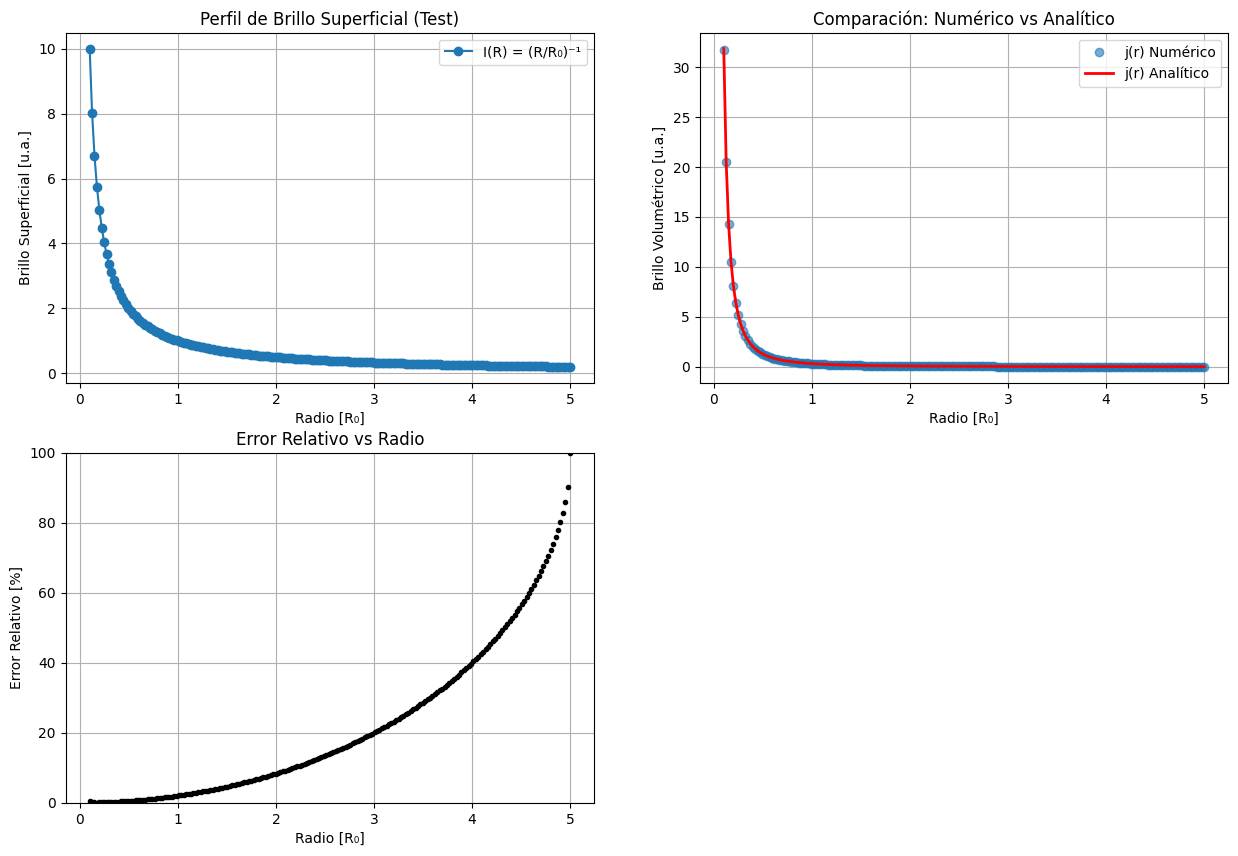

In [15]:
# Parámetros
R0 = 1.0  # Radio característico
N = 200   # Número de puntos

# Usamos espaciado logarítmico para mejor muestreo
R_min, R_max = 0.1, 5
R_test = np.linspace(R_min, R_max, N)

# Crear el perfil de brillo superficial sintético
# Usaremos I(R) = (R/R0)^(-1)
I_test = (R_test/R0)**(-1)

# Calcular j(r) numéricamente 
j_numerical = abel_inversion(R_test, I_test)

# Calcular j(r) analíticamente
j_analytical = R0 / (np.pi * R_test**2)

#comparamos
plt.figure(figsize=(15, 10))

# Grafico 1: Perfil de Brillo Superficial
plt.subplot(2, 2, 1)
plt.plot(R_test, I_test, 'o-', label='I(R) = (R/R₀)⁻¹')
plt.xlabel('Radio [R₀]')
plt.ylabel('Brillo Superficial [u.a.]')
plt.title('Perfil de Brillo Superficial (Test)')
plt.legend()
plt.grid(True)

# Grafico 2: Comparación de j(r)
plt.subplot(2, 2, 2)
plt.plot(R_test, j_numerical, 'o', label='j(r) Numérico', alpha=0.6)
plt.plot(R_test, j_analytical, '-r', label='j(r) Analítico', linewidth=2)
plt.xlabel('Radio [R₀]')
plt.ylabel('Brillo Volumétrico [u.a.]')
plt.title('Comparación: Numérico vs Analítico')
plt.legend()
plt.grid(True)

# Grafico 3: Error Relativo
plt.subplot(2, 2, 3)
error_relativo = np.abs(j_numerical - j_analytical) / j_analytical
plt.plot(R_test, error_relativo * 100, 'k.')  # Mostramos en porcentaje
plt.xlabel('Radio [R₀]')
plt.ylabel('Error Relativo [%]')
plt.title('Error Relativo vs Radio')
plt.grid(True)
plt.ylim(0, 100)  # Limitamos a 100% para mejor visualización


# Calcular estadísticas del error
error_relativo_valid = error_relativo[np.isfinite(error_relativo)]
print("Estadísticas del error (en porcentaje):")
print(f"Error relativo promedio: {np.mean(error_relativo_valid)*100:.2f}%")
print(f"Error relativo mediano: {np.median(error_relativo_valid)*100:.2f}%")
print(f"Error máximo: {np.max(error_relativo_valid)*100:.2f}%")
print(f"Error mínimo: {np.min(error_relativo_valid)*100:.2f}%")
print(f"Fracción de puntos válidos: {len(error_relativo_valid)/len(error_relativo):.1%}")

# Análisis por regiones
r_inner = R_test < R0
r_outer = R_test >= R0
print("\nError promedio por regiones:")
print(f"Region interna (r < R0): {np.mean(error_relativo[r_inner])*100:.2f}%")
print(f"Region externa (r ≥ R0): {np.mean(error_relativo[r_outer])*100:.2f}%")

/tmp/ipykernel_4986/992863956.py:53: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, error = quad(integrand, r_eps, R_sorted[-1], args=(r,), limit=200, epsabs=1e-8, epsrel=1e-8)


/tmp/ipykernel_4986/992863956.py:53: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, error = quad(integrand, r_eps, R_sorted[-1], args=(r,), limit=200, epsabs=1e-8, epsrel=1e-8)


Advertencia: Error grande en r = 5 (err=1.75e-10)


/tmp/ipykernel_4986/992863956.py:53: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result, error = quad(integrand, r_eps, R_sorted[-1], args=(r,), limit=200, epsabs=1e-8, epsrel=1e-8)


Advertencia: Error grande en r = 5 (err=1.75e-10)


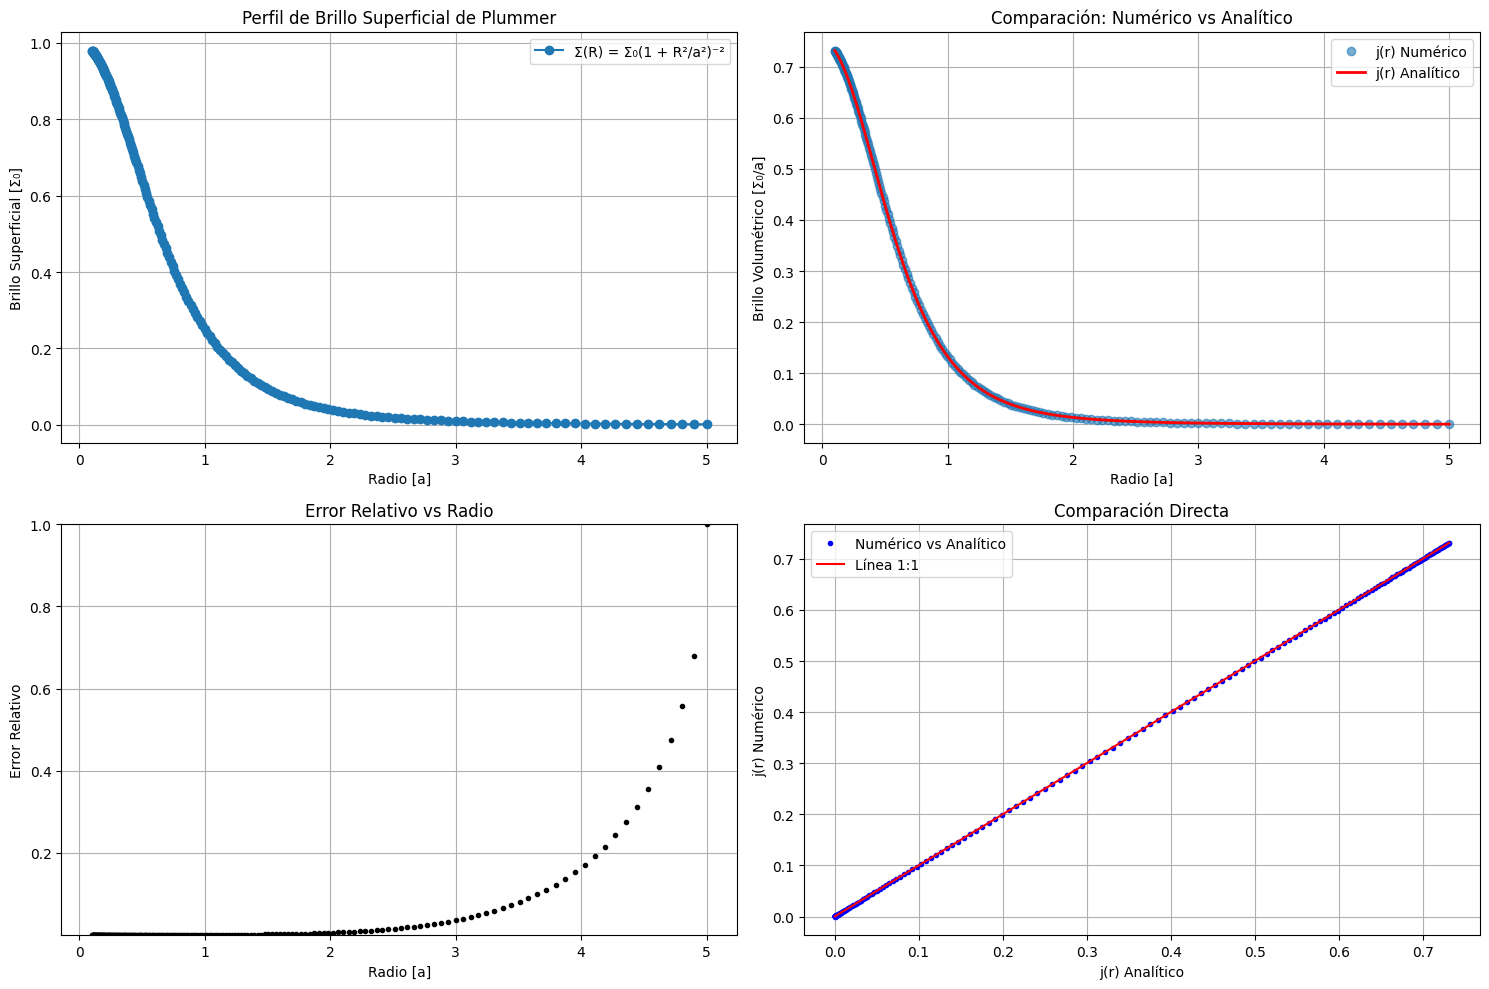

Error relativo promedio: 3.26%
Error relativo mediano: 0.03%
Error máximo: 100.00%
Error mínimo: 0.01%
Fracción de puntos válidos: 100.0%


In [16]:
# Test con el perfil de Plummer
# Parámetros
Sigma0 = 1.0  # Intensidad central
a = 1.0       # Radio de escala
N = 200       # Número de puntos

# Usamos espaciado logarítmico para mejor muestreo
R_min, R_max = 0.1, 5
R_plummer = np.logspace(np.log10(R_min), np.log10(R_max), N)

# Crear el perfil de brillo superficial de Plummer
I_plummer = Sigma0 * (1 + (R_plummer/a)**2)**(-2)

# Calcular j(r) numéricamente usando nuestra función
j_numerical_plummer = abel_inversion(R_plummer, I_plummer)

# Calcular j(r) analíticamente para el perfil de Plummer
j_analytical_plummer = (3*Sigma0/(4*a)) * (1 + (R_plummer/a)**2)**(-5/2)

# Graficar comparación
plt.figure(figsize=(15, 10))

# Grafico 1: Perfil de Brillo Superficial
plt.subplot(2, 2, 1)
plt.plot(R_plummer, I_plummer, 'o-', label='Σ(R) = Σ₀(1 + R²/a²)⁻²')
plt.xlabel('Radio [a]')
plt.ylabel('Brillo Superficial [Σ₀]')
plt.title('Perfil de Brillo Superficial de Plummer')
plt.legend()
plt.grid(True)
#plt.xscale('log')
#plt.yscale('log')

# Grafico 2: Comparación de j(r)
plt.subplot(2, 2, 2)
plt.plot(R_plummer, j_numerical_plummer, 'o', label='j(r) Numérico', alpha=0.6)
plt.plot(R_plummer, j_analytical_plummer, '-r', label='j(r) Analítico', linewidth=2)
plt.xlabel('Radio [a]')
plt.ylabel('Brillo Volumétrico [Σ₀/a]')
plt.title('Comparación: Numérico vs Analítico')
plt.legend()
plt.grid(True)
#plt.xscale('log')
#plt.yscale('log')

# Grafico 3: Error Relativo
plt.subplot(2, 2, 3)
error_relativo_plummer = np.abs(j_numerical_plummer - j_analytical_plummer) / j_analytical_plummer
plt.plot(R_plummer, error_relativo_plummer, 'k.')
plt.xlabel('Radio [a]')
plt.ylabel('Error Relativo')
plt.title('Error Relativo vs Radio')
plt.grid(True)
#plt.xscale('log')
#plt.yscale('log')
plt.ylim(1e-6, 1)  # Limitamos el rango del error para mejor visualización

# Grafico 4: Comparación directa
plt.subplot(2, 2, 4)
plt.plot(j_analytical_plummer, j_numerical_plummer, 'b.', label='Numérico vs Analítico')
plt.plot([j_analytical_plummer.min(), j_analytical_plummer.max()], 
         [j_analytical_plummer.min(), j_analytical_plummer.max()], 
         'r-', label='Línea 1:1')
plt.xlabel('j(r) Analítico')
plt.ylabel('j(r) Numérico')
plt.title('Comparación Directa')
plt.legend()
plt.grid(True)
#plt.xscale('log')
#plt.yscale('log')

plt.tight_layout()
plt.show()

# Calcular estadísticas del error
error_relativo_valid_plummer = error_relativo_plummer[np.isfinite(error_relativo_plummer)]
error_promedio = np.mean(error_relativo_valid_plummer)
error_mediano = np.median(error_relativo_valid_plummer)
print(f"Error relativo promedio: {error_promedio:.2%}")
print(f"Error relativo mediano: {error_mediano:.2%}")
print(f"Error máximo: {np.max(error_relativo_valid_plummer):.2%}")
print(f"Error mínimo: {np.min(error_relativo_valid_plummer):.2%}")
print(f"Fracción de puntos válidos: {len(error_relativo_valid_plummer)/len(error_relativo_plummer):.1%}")

## Prueba con el perfil de Plummer
Probamos ahora con el perfil de Plummer:
- Perfil proyectado: $\Sigma(R) = \Sigma_0(1 + R^2/a^2)^{-2}$
- Solución analítica: $j(r) = \frac{3\Sigma_0}{4a}(1 + r^2/a^2)^{-5/2}$